In [9]:
# Import Libraries 
# -----------------
import numpy as np
import matplotlib.pyplot as plt

# Show Plot in The Notebook
# -------------------------
plt.switch_backend("nbagg") 
from matplotlib import gridspec

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

plt.style.use(['science', 'notebook', 'grid'])

In [10]:
# define constant
n = 1 # 1 electron transfer process
Eeq = 0 # equilibrium potential (V)
coi = 1e-6 # concentration of O (mol/cm3)
cri = 0 # concentration of R (mol/cm3)
Do = 1e-5 # diffusion coefficient of O (cm2/s)
Dr = 1e-5 # diffusion coefficient of R (cm2/s)
D = Do = Dr
ko = 0.05 # transfer rate constant (cm/s)
alpha = 0.55 # transfer coefficient
A = 0.1 # area (cm2)
F = 96485
R = 8.314
T = 298 
f = F/(R*T)

# ----------------------
# voltage sweep

E_start = 0.5 # V
E_mid = -0.5 # V
E_end = 0.5
sweep_rate = 0.01 # V/s 
totalt = (abs(E_start - E_mid) + abs(E_mid - E_end)) / sweep_rate # total simulation time (s)
print(totalt)

200.0


In [11]:
# discretize time
nt = 500 # total time step
dt = totalt / (nt-1) # time step
print(f'time step {round(dt,4)} s')
# ----------------------
Dm = 0.4

# ----------------------
# discretize space
dx = np.sqrt(D*dt/Dm)
print(f'space step: {round(dx,4)} (cm)')
diffusion_layer = np.sqrt(2*D*totalt)
print(f'diffusion layer: {round(diffusion_layer,4)} (cm)')
xmax = round(diffusion_layer * 5,4)
print(f'space domain: {xmax} (cm)')
nx = int(xmax/dx) + 1 # total space step
print(f'number of space step: {nx}')

# time array
t = np.arange(nt)
t = t * dt
# space array
x = np.arange(nx)
x = x * dx

# ----------------------
# applied voltage

E_appf = E_start - t * sweep_rate
E_appf = E_appf[E_appf > E_mid]
E_appb = E_mid + t * sweep_rate
E_appb = E_appb[E_appb < E_start]

E_app = np.concatenate((E_appf,E_appb))

plot = 'nah'
if plot == 'yes':
    plt.plot(t,E_app)
    plt.xlabel('time (s)')
    plt.ylabel('potential (V)')

time step 0.4008 s
space step: 0.0032 (cm)
diffusion layer: 0.0632 (cm)
space domain: 0.3162 (cm)
number of space step: 100


In [12]:
# calculate the e-transfer rate constant
kf = ko * np.exp(-alpha * f * (E_app - Eeq) )
kb = ko * np.exp((1-alpha) * f * (E_app - Eeq))
# kf,kb
# len(kf)

In [13]:
# add C mechanism (EC)
k1r = 0.005 # s-1 
k1o = 0.0005 # s-1

In [14]:
# simulate non faradaic current
Cdl = 5e-6 # F/cm2 (double layer capacitance per area)
Cdl = Cdl * A # F
sigma = 0.1 # S/cm
r_sol = xmax / (A*sigma)
tc = r_sol * Cdl
print(f'characteristic time: {round(tc*10**6,2)} (us)')

nonf_current = sweep_rate * Cdl * (1 - np.exp(-t[:int(nt/2)]/(r_sol * Cdl))) * 10 ** 6
nonf_current = np.concatenate((nonf_current,-nonf_current))

characteristic time: 15.81 (us)


<IPython.core.display.Javascript object>


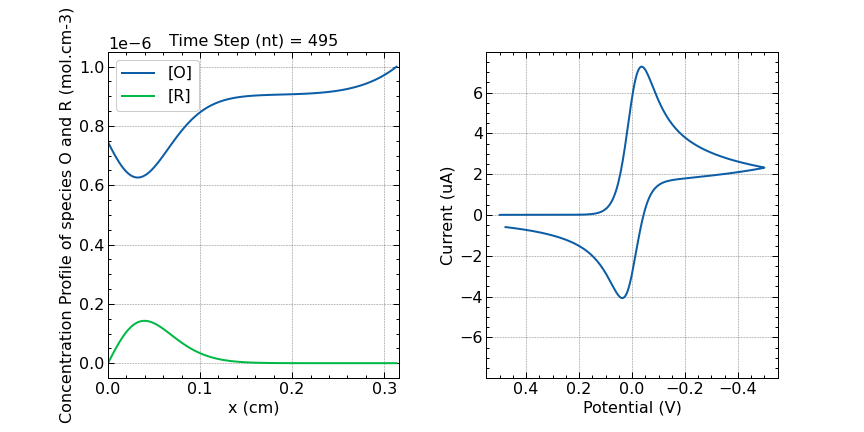

In [15]:
# concentration array
# for O
co = np.zeros(nx) # now
co = co + coi # at t = 0, uniform concentration

conew = np.zeros(nx) # new
d2cox = np.zeros(nx) # 2nd space derivative of c

# for R
cr = np.zeros(nx) # now
cr = cr + cri # at t = 0, uniform concentration

crnew = np.zeros(nx) # new
d2crx = np.zeros(nx) # 2nd space derivative of c

# current array 
current_array = np.zeros(nt) 
# co,cr

# Plot position configuration
# ---------------------------
plt.ion()
fig = plt.figure(figsize=(12, 6))
gs  = gridspec.GridSpec(1,2,width_ratios=[1,1],height_ratios=None,hspace=0.3, wspace=0.3)


# plot concentration
ax1 = plt.subplot(gs[0])
concentrationO, = ax1.plot(x,co, label = '[O]')
concentrationR, = ax1.plot(x,cr, label = '[R]')
ax1.set_xlim(0,xmax) 
# ax1.set_ylim(-np.max(co), np.max(co))
ax1.set_title('Time Step nt = 0')
ax1.legend()
ax1.set_xlabel('x (cm)')
ax1.set_ylabel('Concentration Profile of species O and R (mol.cm-3)')

# plot current
ax2 = plt.subplot(gs[1])
current_line, = ax2.plot(E_app, current_array)
ax2.set_ylim(-np.max(current_array), np.max(current_array))
ax2.invert_xaxis()
ax2.set_xlabel('Potential (V)')
ax2.set_ylabel('Current (uA)')

plt.show()

In [16]:
# simulate
# simulate
idisp = 5
# loop over time
for it in range(nt):
    
    # rate 
    kfi = kf[it]
    kbi = kb[it]
    
    # boundary conditions
    co[-1] = coi
    cr[-1] = cri
    
    # electron transfer process
    # surface reaction
    Jo_0 = - (kfi*co[1] - kbi*cr[1]) / (1 + kfi*dx/D + kbi*dx/D)
    Jr_0 = -Jo_0

    co[0] = co[1] + Jo_0 * dx / D
    cr[0] = cr[1] + Jr_0 * dx / D 
    
    current_array[it] = -n*F*A*Jo_0 * 10** 6 + nonf_current[it]

    
    # diffusion process
    # bulk motion
    
    # 2nd derivative in space 
    for ix in range(1,nx-1):
        d2cox[ix] = (co[ix+1] - 2*co[ix] + co[ix-1]) / dx ** 2
        d2crx[ix] = (cr[ix+1] - 2*cr[ix] + cr[ix-1]) / dx ** 2
    
    
    # time extrapolation
    conew = co + Do * dt * d2cox - k1o * dt * co
    crnew = cr + Dr * dt * d2crx - k1r * dt * cr
    # print(crnew[0])
    
    # remap time levels
    co = conew
    cr = crnew
    
    if (it % idisp) == 0:
        ax1.set_title('Time Step (nt) = %d' %it )
        # ax1.set_ylim(-1.1*np.max(abs(cr)), 1.1*np.max(abs(co)))
        concentrationO.set_ydata(co)
        concentrationR.set_ydata(cr)
        ax2.set_ylim(-1.1*np.max(abs(current_array)), 1.1*np.max(abs(current_array)))
        current_line.set_xdata(E_app[:it])
        current_line.set_ydata(current_array[:it])
        plt.gcf().canvas.draw()
